In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/Final Data/DF_DROPPED_COLS.csv')

#**Brief Summary**
Here I use pre-prepared data (final_data_dummies.csv:).
- Data checking: test the collinearity between features and will eliminate features that have an absolute Pearson correlation value of more than 0.7
- Modeling: applying linear regression with regularization (lasso, ridge and elasticnet) with alpha determination using gridsearch (hyperparameter tuning tool). The model training process uses 5-fold cross-validation

#**Data Checking**

In [5]:
df.columns

Index(['year', 'numcol', 'yieldpercol', 'nCLOTHIANIDIN', 'nIMIDACLOPRID',
       'nTHIAMETHOXAM', 'nACETAMIPRID', 'nTHIACLOPRID', 'nAllNeonic',
       'prevyear_nCLOTHIANIDIN',
       ...
       'StateName_Vermont', 'StateName_Virginia', 'StateName_Washington',
       'StateName_West_Virginia', 'StateName_Wisconsin', 'StateName_Wyoming',
       'Region_Midwest', 'Region_Northeast', 'Region_South', 'Region_West'],
      dtype='object', length=119)

In [6]:
corr = df.corr().abs().unstack().reset_index()
corr = corr.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"correlation"})
corr

,feature1,feature2,correlation
0,year,year,1.000000
1,year,numcol,0.027758
2,year,yieldpercol,0.254740
3,year,nCLOTHIANIDIN,0.280600
4,year,nIMIDACLOPRID,0.318826
...,...,...,...
14156,Region_West,StateName_Wyoming,0.256612
14157,Region_West,Region_Midwest,0.393431
14158,Region_West,Region_Northeast,0.228124
14159,Region_West,Region_South,0.415511


In [ ]:
corr_filter = corr.loc[(corr.correlation > 0.7) & (corr.correlation != 1)]
corr_filter

,feature1,feature2,correlation
5,year,priceperlb,0.725485
126,numcol,totalprod,0.951352
127,numcol,stocks,0.814008
129,numcol,prodvalue,0.901349
265,yieldpercol,prevyearyield,0.771062
...,...,...,...
9037,5 Year Avg Days PM2.5,Prev Days PM2.5,0.944938
9161,5 Year Avg Days PM10,Prev Days PM10,0.949015
9646,StateName_California,Prev Max AQI,0.804798
9661,StateName_California,5 Year Avg Max AQI,0.922845


### Removing some features

In [ ]:
to_remove = corr_filter.groupby(['feature1'])['feature1'].count()[lambda x: x>1].index.tolist()
to_remove

['5 Year Avg 90th Percentile AQI',
 '5 Year Avg Days with AQI',
 '5 Year Avg Good Days',
 '5 Year Avg Max AQI',
 '5 Year Avg Median AQI',
 '5 Year Avg Moderate Days',
 '5 Year Avg Unhealthy Days',
 '5 Year Avg Unhealthy for Sensitive Groups Days',
 '5 Year Avg Very Unhealthy Days',
 'Prev 90th Percentile AQI',
 'Prev Days with AQI',
 'Prev Good Days',
 'Prev Max AQI',
 'Prev Median AQI',
 'Prev Moderate Days',
 'Prev Unhealthy Days',
 'Prev Unhealthy for Sensitive Groups Days',
 'Prev Very Unhealthy Days',
 'StateName_California',
 'nACETAMIPRID',
 'nAllNeonic',
 'nCLOTHIANIDIN',
 'nIMIDACLOPRID',
 'nTHIAMETHOXAM',
 'numcol',
 'prevyear_nCLOTHIANIDIN',
 'prevyear_nTHIAMETHOXAM',
 'prodvalue',
 'stocks',
 'totalprod']

In [ ]:
df2 = df.drop(columns = to_remove)
corr2 = df2.corr().abs().unstack().reset_index()
corr2 = corr2.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"correlation"})
print(corr2.loc[(corr2.correlation > 0.7) & (corr2.correlation != 1)])

                       feature1                   feature2  correlation
2                          year                 priceperlb     0.725485
101                 yieldpercol              prevyearyield     0.771062
186                  priceperlb                       year     0.725485
285                nTHIACLOPRID      prevyear_nTHIACLOPRID     0.784921
561       prevyear_nTHIACLOPRID               nTHIACLOPRID     0.784921
745               prevyearyield                yieldpercol     0.771062
928                    avg_temp               Region_South     0.744423
1795                  dwv-b_max                 dwv-b_prob     0.963583
2257                  iapv_prob                   kbv_prob     0.765273
2349                   kbv_prob                  iapv_prob     0.765273
2623                 dwv-b_prob                  dwv-b_max     0.963583
3202        Prev Hazardous Days  5 Year Avg Hazardous Days     0.743435
3296               Prev Days CO         5 Year Avg Days CO     0

In [ ]:
df3 = df2.drop(columns = ["priceperlb", "prevyear_nTHIACLOPRID", "prevyearyield", "dwv-b_max", "iapv_prob", "5 Year Avg Hazardous Days", "5 Year Avg Days CO", "5 Year Avg Days NO2",\
                         "5 Year Avg Days Ozone", "5 Year Avg Days PM2.5", "5 Year Avg Days PM10"])
corr3 = df3.corr().abs().unstack().reset_index()
corr3 = corr3.rename(columns={"level_0":"feature1", "level_1":"feature2", 0:"correlation"})
print(corr3.loc[(corr3.correlation > 0.7) & (corr3.correlation != 1)])

          feature1      feature2  correlation
572       avg_temp  Region_South     0.744423
6566  Region_South      avg_temp     0.744423


In [ ]:
df3.to_csv('/content/drive/MyDrive/Data/Final Data/final_data_dummies_without_colinearity.csv')
df3.head()

,year,yieldpercol,nTHIACLOPRID,prevyear_nIMIDACLOPRID,prevyear_nACETAMIPRID,NorthDakota_PrevYear,avg_temp,anomaly,varroa,spores,...,StateName_Vermont,StateName_Virginia,StateName_Washington,StateName_West Virginia,StateName_Wisconsin,StateName_Wyoming,Region_Midwest,Region_Northeast,Region_South,Region_West
0,2007,56,0.0,4230.2,0.0,74.0,76.0,1.3,5.559735,0.140715,...,0,0,0,0,0,0,0,0,1,0
1,2006,72,0.0,994.5,0.0,91.0,72.8,-1.9,5.559735,0.140715,...,0,0,0,0,0,0,0,0,1,0
2,2002,86,0.0,1490.8,0.0,96.0,77.3,2.6,5.559735,0.140715,...,0,0,0,0,0,0,0,0,1,0
3,2004,87,0.0,668.3,0.0,87.0,73.8,-0.9,5.559735,0.140715,...,0,0,0,0,0,0,0,0,1,0
4,2005,66,0.0,1323.9,0.0,78.0,76.9,2.2,5.559735,0.140715,...,0,0,0,0,0,0,0,0,1,0


#### Spliting data to train (70%) and test (30%) set. This one later will be shuffled using cross-validation 

In [ ]:
y = df3["yieldpercol"]
X = df3.drop(columns=["yieldpercol"])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

#**Modeling**

## Ridge Regression (L2 Regularization)

In [ ]:
# list of alpha to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]}

#initialising Ridge() function
ridge = Ridge()
# defining cross validation folds as 5
folds = 5

In [ ]:
# Defining GridSearchCV
grid_cv_model = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)

# fiting GridSearchCV() with X_train and y_train
grid_cv_model.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
# Saving GridSearchCV results into a dataframe 
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

# filter cv_results with all param_alpha less than or equal to 200
cv_results = cv_results[cv_results['param_alpha']<=200]

# cv_results head
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017445,0.010204,0.006831,0.001892,0.0001,{'alpha': 0.0001},-8.857319,-8.404100,-9.423783,-8.295798,...,-9.037013,0.706240,15,-7.603979,-7.734181,-7.514773,-7.890944,-7.317449,-7.612265,0.194430
1,0.016165,0.002762,0.010214,0.003874,0.001,{'alpha': 0.001},-8.856991,-8.402446,-9.423605,-8.292101,...,-9.035530,0.706795,14,-7.603836,-7.734406,-7.514907,-7.890938,-7.317552,-7.612328,0.194413
2,0.025448,0.010559,0.014759,0.005857,0.01,{'alpha': 0.01},-8.854796,-8.387305,-9.421745,-8.264898,...,-9.023295,0.710311,13,-7.603134,-7.737111,-7.516233,-7.890951,-7.318743,-7.613234,0.194272
3,0.020362,0.007898,0.010546,0.006222,0.05,{'alpha': 0.05},-8.854227,-8.336173,-9.417107,-8.231446,...,-8.994834,0.709247,11,-7.604993,-7.748058,-7.521839,-7.893380,-7.323577,-7.618369,0.194345
4,0.017363,0.003719,0.007043,0.000157,0.1,{'alpha': 0.1},-8.856470,-8.287321,-9.411017,-8.225825,...,-8.974042,0.704358,10,-7.610675,-7.761335,-7.527813,-7.901003,-7.329548,-7.626075,0.195807


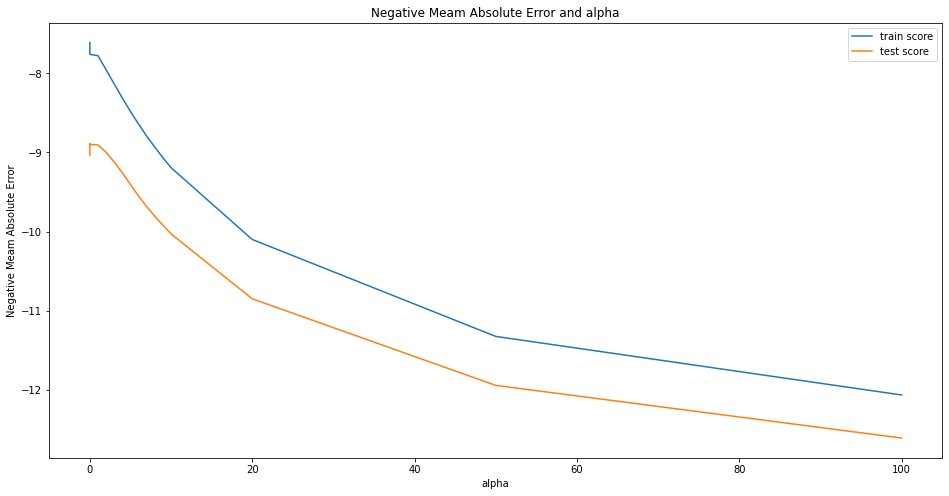

In [ ]:
# changing datatype of 'param_alpha' into int
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper right')

plt.show()

In [ ]:
# checking best alpha from model_cv

grid_cv_model.best_params_

{'alpha': 0.7}

In [ ]:
#seting alpha as 0.7
alpha = 0.7 

# Initialising Ridge() with above alpha
ridge =Ridge(alpha=alpha)

#fitting model
ridge.fit(X_train,y_train)

#printing ridge coeficients
ridge.coef_

array([-1.10892912e+00, -4.38849943e-04, -5.19955375e-05, -6.59787055e-04,
       -1.83761953e-02,  4.51862758e-01,  1.74413863e-01, -1.87154316e-01,
        2.20991394e+00,  1.68783857e+00,  0.00000000e+00,  5.03843420e+00,
        5.00047881e+00,  0.00000000e+00, -3.19190514e+00, -4.49437854e+00,
        0.00000000e+00, -3.07480927e+00, -4.83816371e+00,  6.53221978e+00,
        0.00000000e+00,  1.70645244e+00,  1.61973197e+00,  2.33493966e+00,
        0.00000000e+00,  4.15040813e+00, -2.74787997e-01, -2.99311463e-01,
        3.94737035e-01, -5.11165060e-02, -4.71453393e-02,  3.08757636e-02,
        2.17947139e-02,  2.16606052e-02, -4.60506496e+00,  4.05187374e+00,
        8.07159327e+00,  6.30479548e+00,  9.61195568e+00, -6.50909750e+00,
        3.80290900e+01, -9.73350803e+00, -1.56290359e+00, -7.36820214e+00,
       -6.99336861e+00, -8.36581802e+00, -1.23667165e+01,  3.28623330e+01,
       -2.02937697e+01, -9.01882611e+00,  6.26209937e+00,  8.38758019e+00,
        2.40401879e+01, -

##Lasso Regression (L1 Regularization)

In [ ]:
# Initialising Lasso()
lasso = Lasso()

#usig same attributes used for Ridge tuning except estimator here would be lasso
grid_cv_model = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)
#fiting model_cv
grid_cv_model.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
# Saving model_cv results into a dataframe
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

# cv_results head
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.080704,0.040352,0.005811,0.002841,0.0001,{'alpha': 0.0001},-8.852308,-8.398218,-9.423780,-8.253134,...,-9.025732,0.715677,3,-7.602697,-7.735222,-7.514556,-7.890652,-7.317650,-7.612155,0.194450
1,0.120834,0.017658,0.009139,0.002890,0.001,{'alpha': 0.001},-8.838951,-8.358815,-9.419955,-8.193173,...,-8.995337,0.724340,2,-7.602365,-7.739837,-7.515658,-7.891713,-7.318258,-7.613566,0.195053
2,0.092314,0.009044,0.007089,0.002885,0.01,{'alpha': 0.01},-8.839857,-8.081872,-9.343429,-8.074461,...,-8.866833,0.740760,1,-7.633235,-7.798232,-7.539251,-7.910272,-7.350538,-7.646306,0.195893
3,0.025396,0.010787,0.007012,0.006331,0.05,{'alpha': 0.05},-9.154790,-8.202177,-9.541102,-8.265712,...,-9.035703,0.709332,4,-7.938454,-8.182677,-7.800637,-8.164332,-7.727671,-7.962754,0.185006
4,0.027148,0.004659,0.006968,0.001754,0.1,{'alpha': 0.1},-9.716319,-8.907036,-9.966895,-8.900142,...,-9.564368,0.573901,5,-8.592755,-8.827342,-8.425521,-8.783538,-8.402061,-8.606243,0.175984


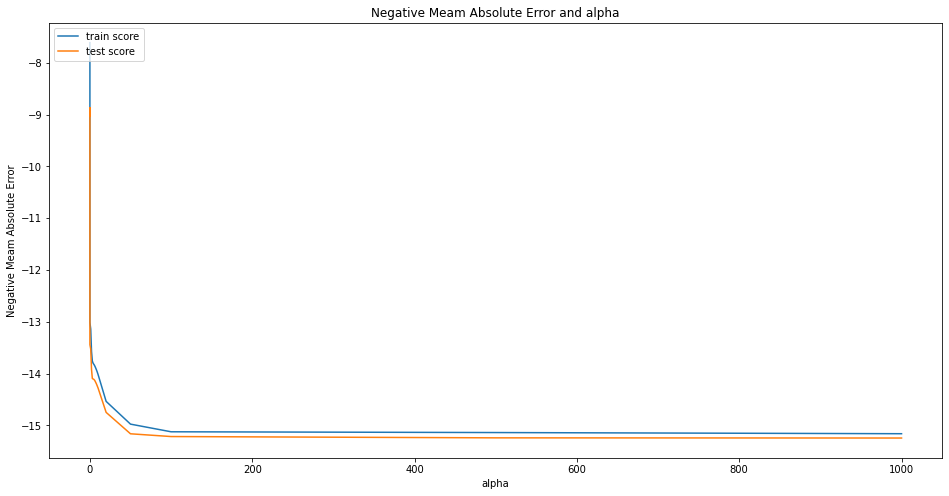

In [ ]:
# changing param_alpha datatype to float
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [ ]:
# Checking best  alpha from model_cv
grid_cv_model.best_params_

{'alpha': 0.01}

In [ ]:
# Seting alpha = 0.01
alpha = 0.01

# Defining lasso with above alpha
lasso =Lasso(alpha=alpha)
  
# fiting lasso
lasso.fit(X_train,y_train)

Lasso(alpha=0.01)

In [ ]:
# printing lasso coeficients
lasso.coef_

array([-1.08376281e+00, -5.64133084e-04, -3.70504771e-05, -5.10762845e-04,
       -1.79338963e-02,  4.40809372e-01,  1.80417149e-01, -2.02404304e-01,
        1.24682437e+00,  1.42494649e+00,  0.00000000e+00,  5.39542191e+00,
        4.54278832e+00,  0.00000000e+00, -3.36853965e+00, -3.99236519e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  8.08321815e+00,
        0.00000000e+00, -9.42988210e-02,  4.01739575e+00,  1.67303616e+00,
        0.00000000e+00,  1.60142661e+00, -2.99632273e-01, -3.52208189e-01,
        1.81719645e+00, -6.59428623e-02, -5.24728613e-02,  3.12358965e-02,
        1.06630781e-02,  8.02319304e-03,  0.00000000e+00,  8.30166814e+00,
        1.20607387e+01,  8.35806649e+00,  1.79370364e+01, -6.77762917e-01,
        5.14794568e+01, -7.75324844e+00, -6.31333634e-01, -7.22202917e+00,
       -5.45548710e+00, -8.07168987e+00, -8.41435948e+00,  3.99104615e+01,
       -2.25577402e+01, -3.67315085e-01,  6.66384520e+00,  1.09522352e+01,
        3.25042345e+01, -

##ElasticNet Regression

In [ ]:
# Initialising ElasticNet()
elasticnet = ElasticNet() 

#using same attributes used for Ridge tuning except estimator here would be ElasticNet
grid_cv_model = GridSearchCV(estimator=elasticnet,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)
#fitingmodel_cv
grid_cv_model.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [ ]:
# Saving model_cv results into a dataframe
cv_results = pd.DataFrame(grid_cv_model.cv_results_)

# cv_results head
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.217142,0.043474,0.010970,0.005646,0.0001,{'alpha': 0.0001},-8.851694,-8.366367,-9.420333,-8.231767,...,-9.007358,0.714297,2,-7.603106,-7.740997,-7.518062,-7.891193,-7.320606,-7.614793,0.194095
1,0.213836,0.020612,0.009038,0.001419,0.001,{'alpha': 0.001},-8.846465,-8.182883,-9.384773,-8.210361,...,-8.929029,0.704188,1,-7.634604,-7.799012,-7.543115,-7.924967,-7.347180,-7.649776,0.200585
2,0.047507,0.018301,0.012402,0.004294,0.01,{'alpha': 0.01},-9.021978,-8.312730,-9.290910,-8.496364,...,-9.056102,0.653843,3,-8.037935,-8.217448,-7.943630,-8.260255,-7.755041,-8.042862,0.184636
3,0.023970,0.004581,0.006897,0.002723,0.05,{'alpha': 0.05},-9.755019,-10.326213,-10.004241,-10.475705,...,-10.384994,0.549830,4,-9.653637,-9.593836,-9.605142,-9.640214,-9.376922,-9.573950,0.100925
4,0.036678,0.017478,0.008384,0.003311,0.1,{'alpha': 0.1},-10.613185,-11.515254,-10.610093,-11.693385,...,-11.383484,0.709836,5,-10.794881,-10.560399,-10.770052,-10.663843,-10.426319,-10.643099,0.136688


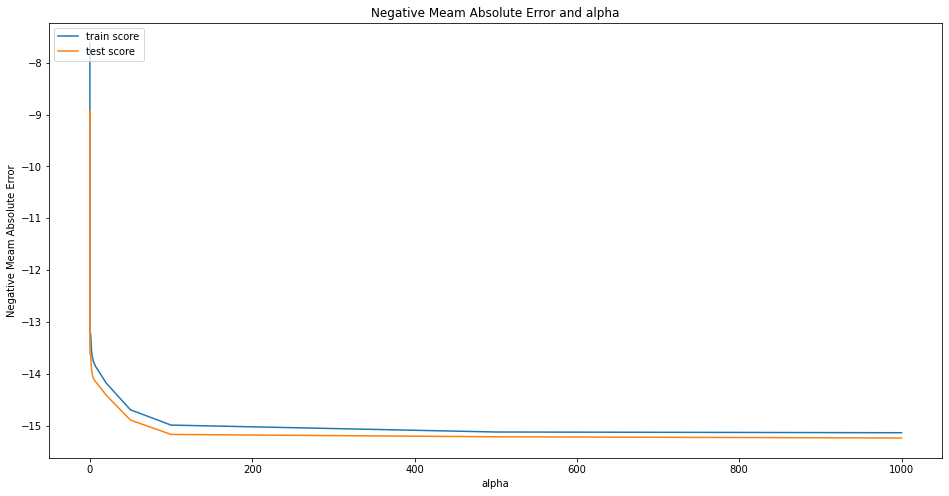

In [ ]:
# change param_alpha datatype to float
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.figure(figsize=(16,8))
plt.plot(cv_results['param_alpha'],cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'],cv_results['mean_test_score'])

plt.title('Negative Meam Absolute Error and alpha')
plt.xlabel('alpha')
plt.ylabel('Negative Meam Absolute Error')
plt.legend(['train score','test score'],loc='upper left')

plt.show()

In [ ]:
# Checking best  alpha from model_cv
grid_cv_model.best_params_

{'alpha': 0.001}

In [ ]:
# Seting alpha = 0.001
alpha = 0.001

# Defining ElasticNet with above alpha
elasticnet = ElasticNet(alpha=alpha)
  
# fiting elastic net
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.001)

In [ ]:
# printing ElasticNet coeficients
elasticnet.coef_

array([-1.09622446e+00, -5.68975903e-04, -4.44327176e-05, -5.82460519e-04,
       -2.03279725e-02,  3.70084804e-01,  2.73020440e-01, -1.34122915e-01,
        1.90629890e+00,  1.41464988e+00,  0.00000000e+00,  5.44411920e+00,
        4.68222792e+00,  0.00000000e+00, -3.24132539e+00, -4.19481229e+00,
        0.00000000e+00, -1.30616350e+00, -3.78166826e+00,  8.48029686e+00,
        0.00000000e+00,  1.57270096e-01,  3.07506586e+00,  2.22162236e+00,
        0.00000000e+00,  2.21806382e+00, -3.09095238e-01, -3.38034701e-01,
        1.66784500e+00, -5.37519236e-02, -4.36306466e-02,  2.95871879e-02,
        1.64037946e-02,  9.93973631e-03, -3.93637160e+00,  6.94944317e+00,
        7.40277260e+00,  6.74657632e+00,  1.27468772e+01, -6.10780350e+00,
        4.53518046e+01, -1.04602150e+01, -1.11293938e+00, -7.82627941e+00,
       -7.13873040e+00, -8.34865538e+00, -1.42271372e+01,  3.46646739e+01,
       -2.13002833e+01, -8.07946443e+00,  5.90663311e+00,  8.78011671e+00,
        2.61247504e+01, -

###Model Evaluation

In [ ]:
# Calculating all 3 predictions 
pred_by_lasso =  lasso.predict(X_test)
pred_by_ridge = ridge.predict(X_test)
pred_by_elasticnet = elasticnet.predict(X_test)


# printing RMSE for all 3 techniques
print("RMSE")
print(f'Lasso RMSE: {np.sqrt(mse(y_test,pred_by_lasso))}')
print(f'Ridge RMSE: {np.sqrt(mse(y_test,pred_by_ridge))}')
print(f'ElasticNet RMSE: {np.sqrt(mse(y_test,pred_by_elasticnet))}')

print("\nR-squared")
print(f'Lasso R2: {r2_score(y_test, pred_by_lasso)}')
print(f'Ridge R2: {r2_score(y_test, pred_by_ridge)}')
print(f'ElasticNet R2: {r2_score(y_test, pred_by_elasticnet)}')

RMSE
Lasso RMSE: 11.449650960713496
Ridge RMSE: 11.532895296242737
ElasticNet RMSE: 11.498184340647965

R-squared
Lasso R2: 0.6536251181205339
Ridge R2: 0.6485701929667818
ElasticNet R2: 0.6506824305346566


I guess we're good with Lasso :)